In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

## Load results

In [17]:
def load_sparql_times(system, data_size):
    sparql_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/results/{system}/{data_size}/times_{system}.csv"
    df_sparql = pd.read_csv(sparql_times)
    df_sparql['total_time'] = df_sparql['load_time'] + df_sparql['exec_time']
    
    return df_sparql


def load_sparql_times_agg(system, data_size):
    df_sparql = load_sparql_times(system, data_size)
    df_sparql_agg = df_sparql.groupby('query')[['load_time', 'exec_time', 'total_time']].mean().reset_index()
    df_sparql_agg['nr'] = df_sparql_agg['query'].str.slice(len("query-"), -len(".sparql"))
    
    return df_sparql_agg

In [18]:
def load_n3_times(type, data_size):
    n3_times = f"/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/gmark_50_new/mix/n3/results/{data_size}/times_n3.csv"
    df_n3 = pd.read_csv(n3_times)
    
    df_n3 = df_n3[df_n3['type']==type]
    
    df_n3['id'] = df_n3.apply(lambda x: f"{x['query']},{x['type']}", axis=1)
    df_n3_failed = df_n3[df_n3['reas_time']==-1]['id']
    df_n3_filt = df_n3[~df_n3['id'].isin(df_n3_failed)]
    
    df_n3_total = df_n3_filt[df_n3_filt['phase'].isna() | (df_n3_filt['phase']=='total')]
    df_n3_total['total_time'] = df_n3_total['netw_time'] + df_n3_total['reas_time']
    
    return df_n3_total


def load_n3_times_agg(type, data_size):
    df_n3_total = load_n3_times(type, data_size)    
    df_n3_agg = df_n3_total.groupby('query')[['netw_time', 'reas_time', 'total_time']].mean().reset_index()
    df_n3_agg['nr'] = df_n3_agg['query'].str.slice(len("query-"), -len(".n3"))

    return df_n3_agg

## Check outliers

In [6]:
def check_query_stdev(df, time_col, limit=10):
    for query in df['query'].unique():
        df_query = df[df['query']==query]
        stdev = df_query[time_col].describe()['std']
        if stdev > limit:
            print(query, stdev)
            print(df_query)
            print()

In [ ]:
check_query_stdev(load_sparql_times('jena', 50), time_col='exec_time', limit=50)
check_query_stdev(load_sparql_times('jena', 100),time_col='exec_time',  limit=50)

## - jena, data_size 100:
# outliers (exec time): query-11 (100637 vs. avg. 153), query-2 (309138 vs. avg. 39551)
# (replaced with averages)

In [ ]:
check_query_stdev(load_sparql_times('rdflib', 50), time_col='exec_time', limit=50)

In [9]:
check_query_stdev(load_sparql_times('rdf4j', 50), time_col='exec_time', limit=100)
check_query_stdev(load_sparql_times('rdf4j', 100), time_col='exec_time', limit=100)

query-6.sparql 108.89214847728921
     run           query        data  load_time  exec_time  total_time nr
46     0  query-6.sparql  data_50.nt         93       2245        2338  6
96     1  query-6.sparql  data_50.nt         94       2229        2323  6
146    2  query-6.sparql  data_50.nt         93       2272        2365  6
196    3  query-6.sparql  data_50.nt         92       2496        2588  6
246    4  query-6.sparql  data_50.nt         91       2283        2374  6

query-2.sparql 139.6363133285894
     run           query         data  load_time  exec_time  total_time nr
12     0  query-2.sparql  data_100.nt         96      15818       15914  2
61     1  query-2.sparql  data_100.nt        102      15742       15844  2
110    2  query-2.sparql  data_100.nt         99      15797       15896  2
159    3  query-2.sparql  data_100.nt         96      16033       16129  2
208    4  query-2.sparql  data_100.nt         94      15657       15751  2

query-28.sparql 105.24637760987311
  

In [ ]:
check_query_stdev(load_n3_times('fwd', 50), time_col='reas_time', limit=50)
check_query_stdev(load_n3_times('fwd', 100), time_col='reas_time', limit=50)

## Check statistics

In [4]:
desc_path = "/Users/wvw/git/n3/sparql2n3/SPARQL-to-N3/SPIN-to-N3/property-paths/results/july"

def describe_sparql(system, data_size):
    load_sparql_times_agg(system, data_size).describe().to_csv(os.path.join(desc_path, f"{system}-{data_size}.csv"))
    
def describe_n3(type, data_size):
    load_n3_times_agg(type, data_size).describe().to_csv(os.path.join(desc_path, f"n3_{type}-{data_size}.csv"))

In [10]:
describe_sparql('rdflib', 50)
describe_sparql('jena', 50)
describe_sparql('jena', 100)
describe_sparql('rdf4j', 50)
describe_sparql('rdf4j', 100)

In [5]:
describe_n3('direct', 50)
describe_n3('bwd', 50)
describe_n3('fwd', 50)
describe_n3('fwd', 100)

In [15]:
import matplotlib.pyplot as plt

def plot_systems(data_size, lim=None, incl_only=['n3_dir', 'n3_bwd', 'n3_fwd','jena', 'rdflib', 'rdf4j']):
    fig, ax = plt.subplots()
    if lim is not None:
        ax.set_ylim(0, lim)

    if 'n3_fwd' in incl_only:
        load_n3_times_agg('fwd', data_size).plot(x='nr', y='reas_time', ax=ax, label='fwd')
    if 'n3_bwd' in incl_only:
        load_n3_times_agg('bwd', data_size).plot(x='nr', y='reas_time', ax=ax, label='bwd')
    if 'n3_dir' in incl_only:
        load_n3_times_agg('direct', data_size).plot(x='nr', y='reas_time', ax=ax, label='direct')

    if 'jena' in incl_only:
        load_sparql_times_agg('jena', data_size).plot(x='nr', y='exec_time', ax=ax, label='jena')
    if 'rdflib' in incl_only:
        load_sparql_times_agg('rdflib', data_size).plot(x='nr', y='exec_time', ax=ax, label='rdflib')
    if 'rdf4j' in incl_only:
        load_sparql_times_agg('rdf4j', data_size).plot(x='nr', y='exec_time', ax=ax, label='rdf4j')

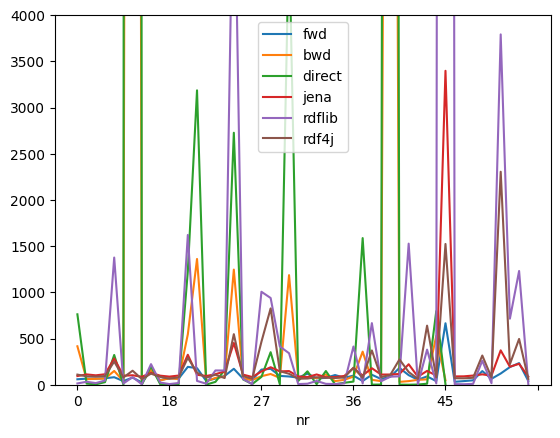

In [20]:
plot_systems(50, lim=4000)

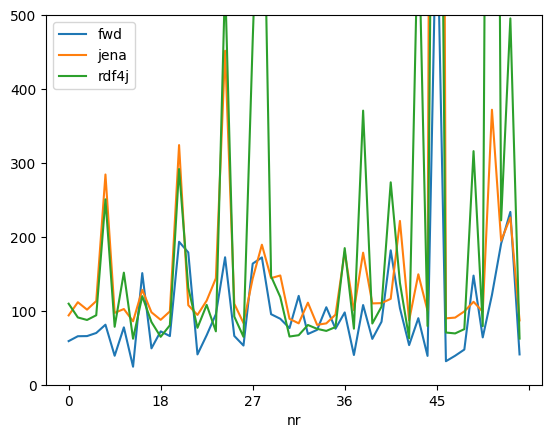

In [21]:
plot_systems(50, lim=500, incl_only=['n3_fwd', 'jena', 'rdf4j'])

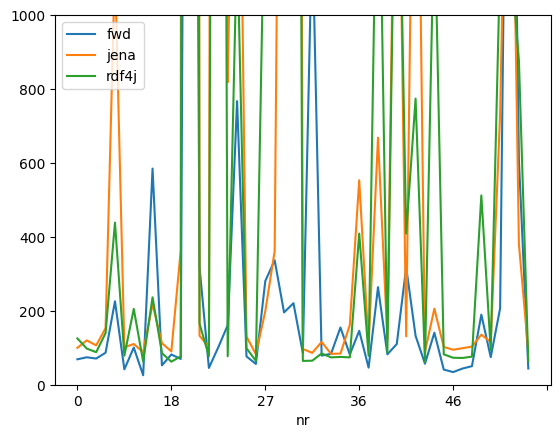

In [24]:
plot_systems(100, lim=1000, incl_only=['n3_fwd', 'jena', 'rdf4j'])